<a href="https://www.kaggle.com/code/afi1289/linear-regression-with-model-deployment?scriptVersionId=100646147" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### This is a starter notebook for Linear Regression. It covers some Data Preprocessing and Feature Engineering techniques. Please upvote and share the notebook if you found it helpful in any way. Thank you in advance!
### **NOTE**: The code is inspired by this amazing book: [Machine Learning Bookcamp Build a portfolio of real-life projects](https://www.manning.com/books/machine-learning-bookcamp)

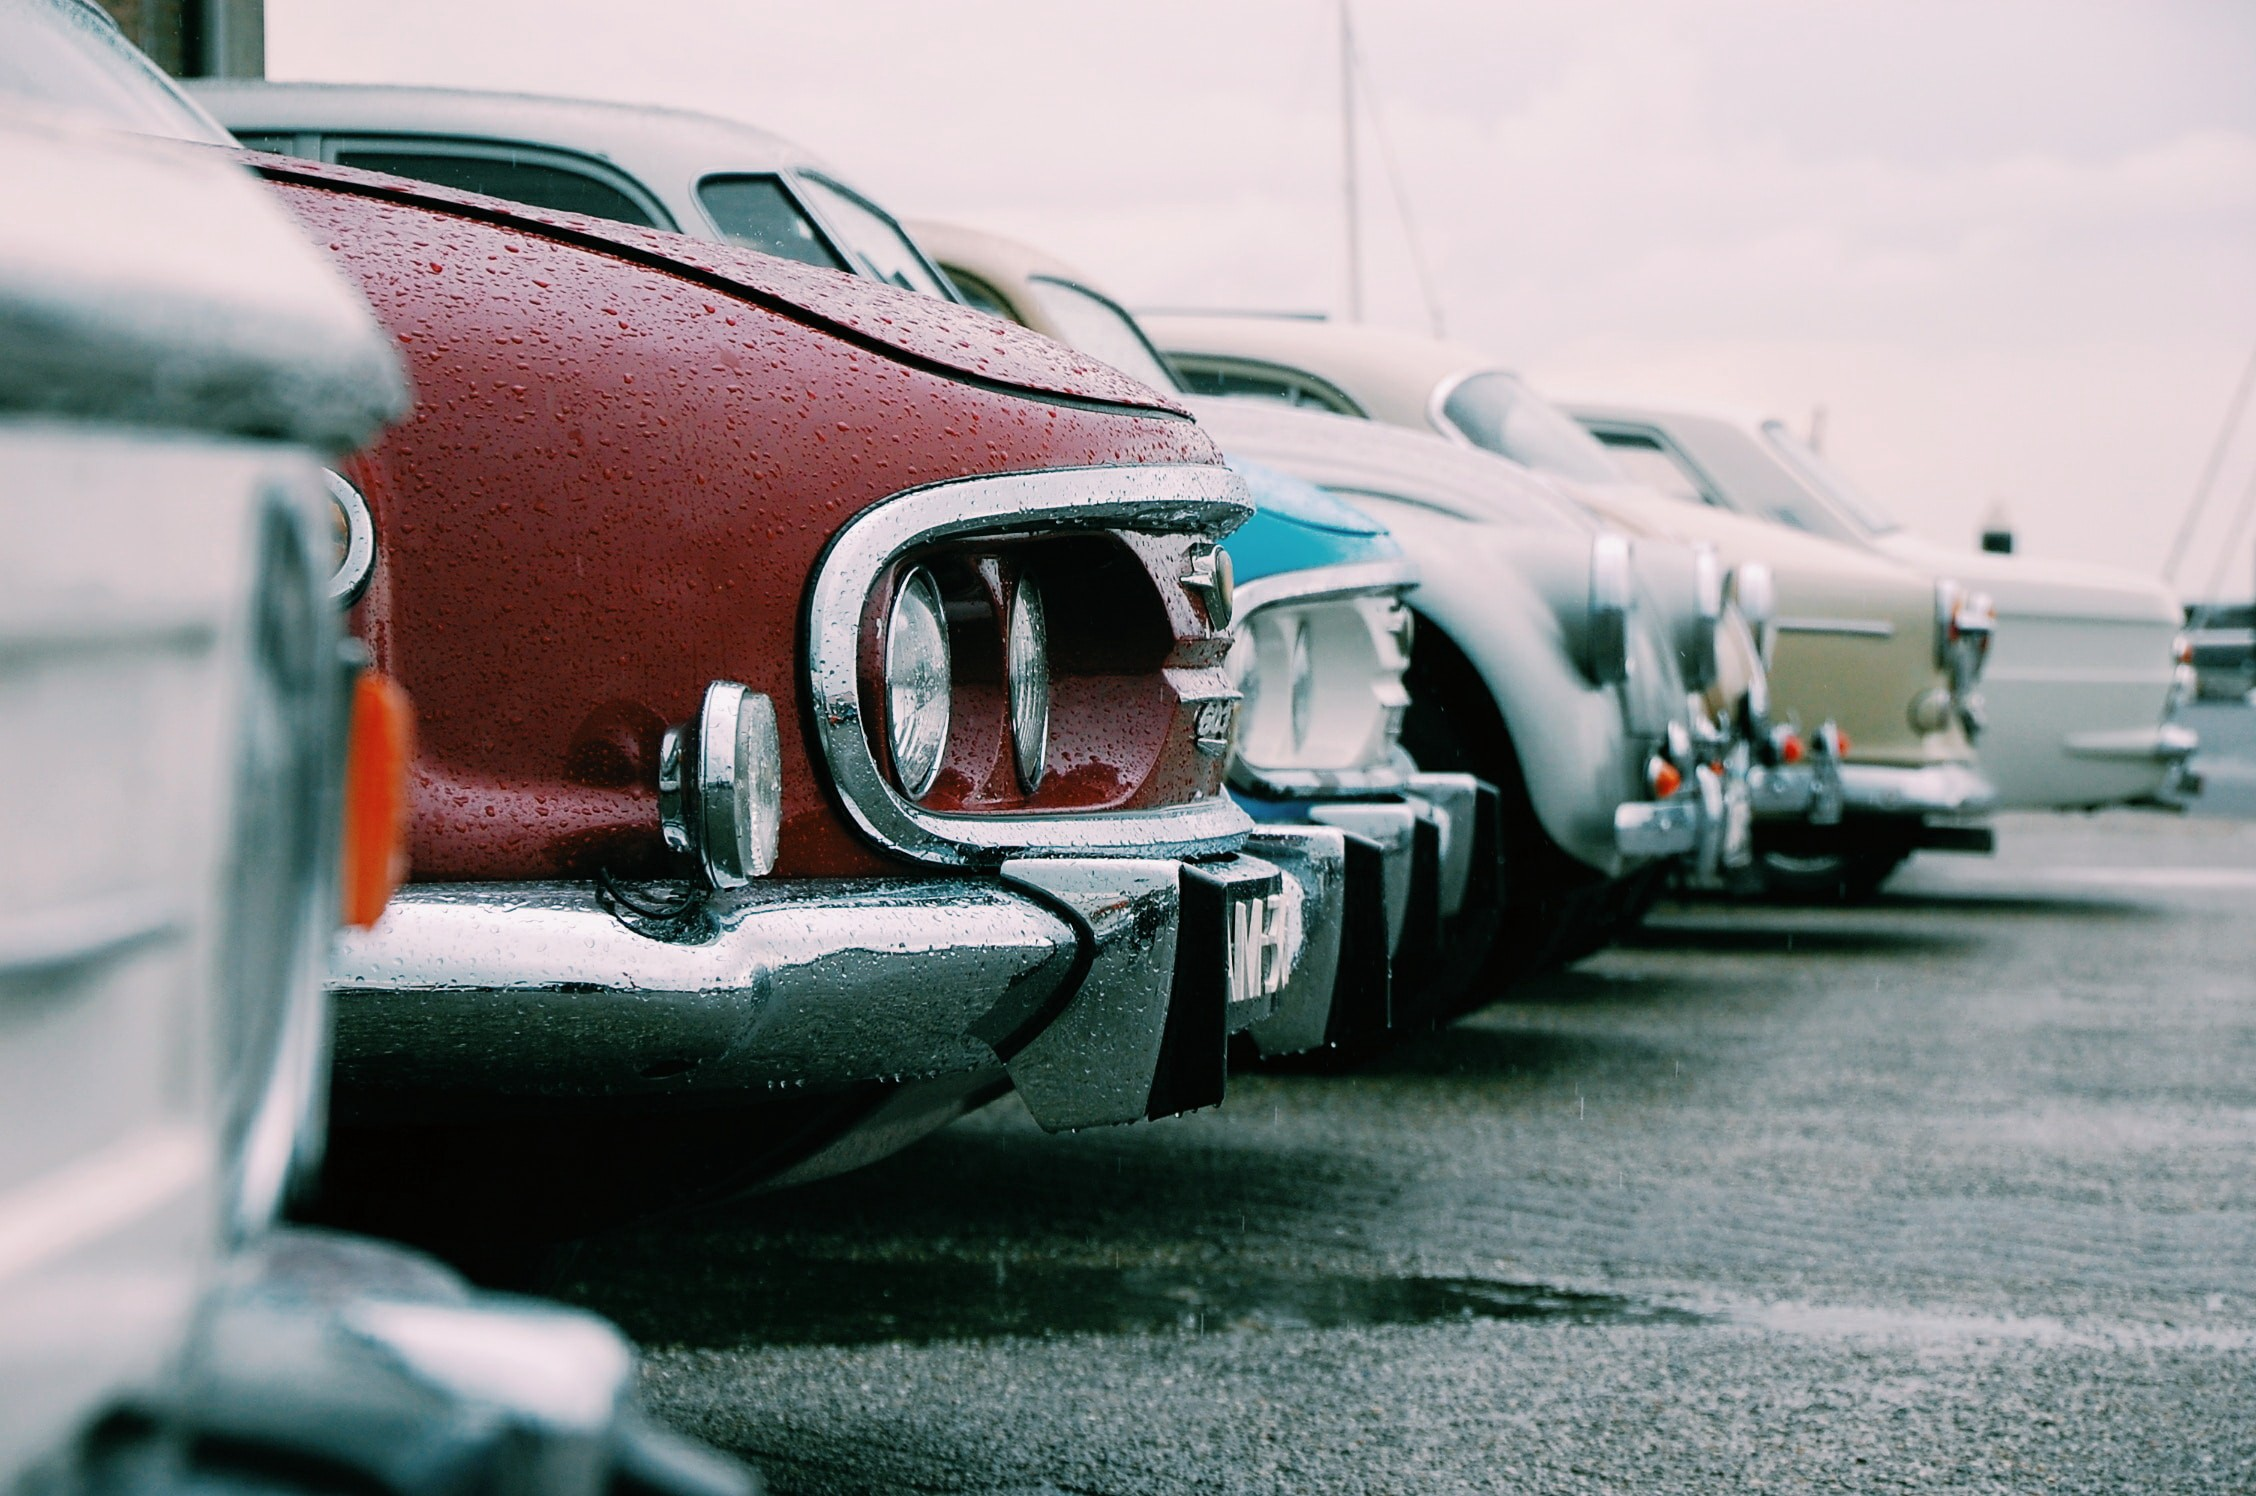

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import random
from plotly.offline import iplot
pd.options.plotting.backend= "plotly"

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Exploratory data analysis:
One of the most important steps in ML and Data Science project is understanding data. At this step we are going to:
* Examine the features 
* Check features distribution
* Examine the dependent variable (The variable we are trying to predict)
* Assess the data quality
* Check the missing values

In our data analysis toolbox, we will use **plotly** for visualization. **Plotly** is an interactive framework that allows users to plot all Matplotlib and Seaborn charts with a full control over what is being plotted.

In [ ]:
# Load the Dataset into a DataFrame
# NOTE: in practice this step can be more than one line of code
df = pd.read_csv('../input/cardataset/data.csv')

In [ ]:
# Check the length of the dataframe
len(df)

In [ ]:
# Check the data types 
df.dtypes

In [ ]:
# Show the first 10 rows to get an idea how the data look like
df.head(10)

* We have almost 12k cars in our dataset!
* There are some incosistencies: 
    * Column names sometimes have spaces and underscores (e.g., `Engine HP` and `Driven_Wheels`)
    * Some featre values are capitalized (e.g., `Transmission type`) or they are just strings with spaces
    
    Therefore we have to make some **preprocessing** steps:  

In [ ]:
# Let's lowercase all the column names and replace spaces with _
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

In [ ]:
# Select only columns with string values (i.e., we are not going to preprocess columns with numeric values)
string_columns= list(df.dtypes[df.dtypes == 'object'].index)
string_columns

In [ ]:
# Let's lowercase and replace spaces with underscores for values in all string columns of the df
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [ ]:
# Check the data again
df.head()

Our dataframe looks better now! But what the columns actually mean?
* `make`: maker of a car (BMW, Toyota, and so on)
* `model`: model of car
* `year`: year when the car was manufactured
* `engine_feul_type`: type of fuel the engine needs
* `engine_hp`: horsepower of the engine
* `engine_cylinders`: number of cylinders in the engine
* `transmission_type`: automatic or manual
* `driven_wheels`: fromn, rear, all
* `number_of_doors`
* `market_category`: luxury, crossover, and so on
* `vehicle_style`: sedan or convertible
* `highway_mpg`: miles per gallon on the highway
* `city_mpg`: miles per gallon n the city
* `popularity`: number of times the car was mentioned in a Twitter stream

and the most important column is the price of the car:
* `msrp`: manufacturer's suggested retail price. This column is our **target variable** which we are trying to predict!

## Target Variable Analysis

### What the values of **Target variable** look like? Visualize them using a **Histogram**:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram (x=df['msrp'],
                            marker=dict(color='rgba(171, 50, 96,0.6)')
                            
                            )
             )
iplot(fig)

### Long tail? **log transformation**!
The long tail would confuse the model. In other words, the model will NOT learn enough.  To solve this Problem we can use log transformation later to get the following result:

In [ ]:
log_price = np.log1p(df['msrp'])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram (x=log_price,
                            marker=dict(color='rgba(171, 50, 96,0.6)')
                            
                            )
             )
iplot(fig)

### Normal or like Normal? Linear Regression works!
* If the target variable (before/after log transformation) has a normal distribution or normal-like distriubtion, the linear regression model can perform well.
* In our case, the distribution of the target variable is not normal because of the large peak in lower prices, but the model can deal with it more easily.

## Something is Missing? Check for **missing values**:


ML algorithms cannot deal with missing values automatically. We need to **deal with them** before modeling step.

In [ ]:
# check missing values for each column
df.isnull().sum()

## Validation Framwork

We split the dataset in order to ensure that our model can generalize on new/unseen data. 

### 1. Splitting Data into validation, test, and training sets

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [ ]:
df_train.head()

## Normlize the target variable values
Our target variable (car prices `msrp`) has a long tail in the distribution of its values. We have to remove this effect by applying log transformation. We will write functions to do that, since it allow you to reproduce these transformations easily. In addition, this enables us to try various transformations and see which combination of transformations works best.

In [ ]:
# Return the natural logarithm of one plus the input array, element-wise
# +1 is important part in cases that have zeros
def transform_func(df, target):
    y_norm = np.log1p(df[target].values)
    return y_norm

# undo the logarithm and apply the exponent function (for final prediction)
def inverse_func(y_norm):
    return np.expm1(y_norm)

In [ ]:
# apply the transformation
y_train = transform_func(df_train, "msrp")
y_val = transform_func(df_val, "msrp")
y_test = transform_func(df_test, "msrp")

In [ ]:
# now the values of the target variable are normalized
fig = go.Figure()
fig.add_trace(go.Histogram (x=y_train, 
                            marker=dict(color='#636EFA'),
                            name='Training'
                            
                            )
             )
fig.add_trace(go.Histogram (x=y_val, 
                            marker=dict(color='#EF553b'),
                            name='Validation'
                            
                            )
             )
fig.add_trace(go.Histogram (x=y_test, 
                            marker=dict(color='#00CC96'),
                            name='Testing'
                            
                            )
             )
iplot(fig)

Training points are more frequent than the others. Therefore, the head of training distribution is bigger.

In [ ]:
# remove the target variable from the dataframe to avoid using it in training later
del df_train['msrp']
del df_val['msrp']
#del df_test['msrp']

## Implement Linear Regression


### 1. Base Solution

In this basic solution, we are going to implement the **normal equation** that will find the **optimal** weights and biases:

$ w = \left ( X^{T}X \right )^{-1}X^{T}y $

Therefore, we need create a **matrix of features** $ X $ from our dataframe. We will select the following features:
* `engine_hp`
* `engine_cylinders`
* `highway_mpg`
* `city_mpg`
* `popularity`

In [ ]:
# implement the normal equation to find the optimal weights and biases

def train_linear_regression(X, y):
    # create an array that contains only ones (it is the dummy feature)
    ones = np.ones(X.shape[0])
    # add the array of ones as the first column of X
    X = np.column_stack([ones, X])
    
    # normal equation formula
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    
    w = XTX_inv.dot(X.T).dot(y)
    
    # return the optimal biases and weights
    return w[0],w[1:]

In [ ]:
# select features and write them to  new variable
base = ['engine_hp','engine_cylinders','highway_mpg','city_mpg','popularity']
df_num = df_train[base]

As mentioned before, the dataset has missing values. Unfortunately, ML methods cannot deal with them. As a naive solution, we are going to fill missing values with `0`:

In [ ]:
# fill the missing values
df_num = df_num.fillna(0)

In this step, we convert our dataframe to a NumPy array

In [ ]:
# convert the dataframe to numpy array
X_train = df_num.values

In [ ]:
# use the normal equation function to get the optimal biases and weights
w_0, w = train_linear_regression(X_train, y_train)

In [ ]:
# apply the new biases and weights on the training data to see how well it predicts (theoretical step)
y_pred = w_0 + X_train.dot(w)

In [ ]:
# visualize to see how good the predictions are
# compare the distribution of traget variable with the distribution of predicted values
fig = go.Figure()
fig.add_trace(go.Histogram (x=y_train, 
                            marker=dict(color='#636EFA'),
                            name='Actual'
                            
                            )
             )
fig.add_trace(go.Histogram (x=y_pred, 
                            marker=dict(color='#EF553b'),
                            name='prediction'
                            
                            )
             )
fig.update_layout(                       
                    title = 'Actual Values vs. Predicted Values', # Title
                    )

iplot(fig)

The result above indicates that our model is **not powerful** enough to capture the distribution of the **target variable**. However, comparing distributions is not always feasible. Let's evaluate model performance with a metric such as **root mean squared error RMSE**

In [ ]:
# RMSE implementaion
def rmse(y,y_pred):
    # computes the difference between the actual values and predictions
    error = y_pred - y
    # compute the squared error, and then calculates its mean
    mse = (error**2).mean()
    
    #return the root
    return np.sqrt(mse)

In [ ]:
rmse(y_train, y_pred)

This number tells us that on average, the model's predictions are off by 0.75. **NOTE** This result alone my not be very useful, but we can use it to compare this model with other models.

### Validating the model

To validate the model, we will use the validation dataset. Therefore, we will create `X_val` matrix follwoing the same steps for `X_train` using a function

In [ ]:
# prepare function to convert a Dataframe into matrix
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [ ]:
X_val = prepare_X(df_val)

In [ ]:
# apply the model (i.e., weights and biases) on X_val to get predictions
y_pred = w_0 + X_val.dot(w)

In [ ]:
# evaluate the model performance using RMSE
rmse(y_val, y_pred)

This number should be used to compare models. Before that, let's do some feature engineering

## Simple Feature Engineering:
To improve our model, we cann add more features to the model: we create others and add them to the existing features. This process called **feature engineering**.

1. Create a new feature, `age` from the feature `year`

In [ ]:
# Note: the dataset was created in 2017
# df_train['age'] = 2017 - df_train['year']
# base = ['engine_hp','engine_cylinders','highway_mpg','city_mpg','popularity']

If you have to repeat the same feature extraction step multiple times, put its logic into preprocessing function: let's put the previous logic into the `prepare_X` function

In [ ]:
# createing the age feature in the prepare_X function
def prepare_X(df):
    #create a copy of the input parameter to prevent side effects
    df = df.copy()
    # create a copy of the base list with basic features
    features = base.copy()
    
    # compute the age feature
    df['age'] = 2017 - df['year']
    # append age to the list of feature used for the model
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [ ]:
# test if adding the feature age leads to any improvements
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation: ', rmse(y_val, y_pred))

The validation error is **improved**! It was 0.76 and it is now 0.517. Let's look at the distribution of predicted values:

In [ ]:
# visualize to see how good the predictions are
# compare the distribution of traget variable with the distribution of predicted values
fig = go.Figure()
fig.add_trace(go.Histogram (x=y_val, 
                            marker=dict(color='#636EFA'),
                            name='Actual'
                            
                            )
             )
fig.add_trace(go.Histogram (x=y_pred, 
                            marker=dict(color='#EF553b'),
                            name='Prediction'
                            
                            )
             )
fig.update_layout(                       
                    title = 'Actual Values vs. Predicted Values', # Title
                    )

iplot(fig)

The **distribution of the predictions** follows the **target distribution** a lot more closely than previously!

## Handling Categorical Variables

You can use categorical variables in a ML model in multiple ways. One of the simplest eays is to use encode such variables by a set of binary features, with a separate feature for each distinct value (**one-hot encoding**)

In [ ]:
# this cell is to understand the logic in the function below

# simple one-hot encoding for the feature 'number_of_doors'
features = base.copy()


# iterate over possible values of the 'number_of_doors' variable
for v in [2,3,4]: 
    # give a feature a meaningful name, such as "num_doors_2" for v=2
    feature = "number_doors_%s" % v
    
    # create the one-hot encoding feature
    value = (df['number_of_doors'] == v).astype(int)
    
    # add the feature back to the dataframe
    #df[feature]= value # uncomment and delete the features later
    features.append(feature)
    

In [ ]:
# handling categorical variables in the prepare_X function

def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df['year']
    features.append('age')
    
    # encode "number_of_doors" feature
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
        
    # encode "make" feature
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
        
    # encode the "engine_fuel_type" feature
    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
    
    # encode the "transmission_type" feature
    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
    
    # encode the "driven_wheels" feature
    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheens_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    # encode the "market_category" feature
    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    # encode the "vehicle_size" feature
    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    # encode the "vehicle_style" feature
    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [ ]:
# test if adding the feature age leads to any improvements
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation: ', rmse(y_val, y_pred))

The result is significantly worse than before. The new features made the score a lot **worse**. The reason for this behavior is numerical instability (normal equation solution).numerical instability issues are typically solved with **regularization**:

In [ ]:
# add regularization to the training function
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

This result is an **improvement** over the previous score.

### Using the model:

We can use our model to predict the price of a specific car. Suppose that we want to predict the price of the following car:

In [ ]:
example = df_test.iloc[2].to_dict()
example 

In [ ]:
# create a dataframe with one row
df_example = pd.DataFrame([example])  # https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
df_example

In [ ]:
# convert the dataframe to numpy array
X_example = prepare_X(df_example)#[0]
X_example

In [ ]:
# apply the new biases and weights on the example to get a prediction 
y_pred = w_0 + X_example.dot(w)
y_pred

However, y_pred is NOT the final prediction! it is the **logarithm** of the price. Therefore, we have to undo the logarithm and apply the **exponent function**:

In [ ]:
final_prediction = inverse_func(y_pred)
final_prediction = np.expm1(y_pred)
final_prediction

The **final prediction** is 39,478  The **real price** is 37,650 So our model is not far from the actual price.

# In Process...

### 2. Gradient Descent (In Process):
It is an optimization algorithm to find the optimal weights and biases. The main idea behind this algorithm is to update the parameters (weights and biases) iteratively to minimize the cost function.

In [ ]:
X_train

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
xtrain = scalerX.transform(X_train)
ytrain = scalery.transform(y_train)
xval = scalerX.transform(X_val)
yval = scalery.transform(y_val)

xtrain = scale(X_train)
ytrain = scale(y_train)
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(xtrain, ytrain)

In [ ]:
xval = scale(X_val)
yval = scale(y_val)

In [ ]:
ypred = sgd_reg.predict(xval)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(yval, ypred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))


In [ ]:
memo = sgd_reg.predict(scale(X_example))
memo

In [ ]:
final_prediction = inverse_func(memo)
final_prediction

#### Some Ideas:

* create a numerical transformation pipelene
`from sklearn.pipeline import Pipeline # handle numerical`

* create a categorical transformation pipeline
`from sklearn.preprocessing import OneHotEncoder`

* create a single transformer that can handle numerical and categorical variables p.74 hands-on
`from sklearn.compose import ColumnTransformer`

* It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain linear Regression. Ridge is a good default.

In [ ]:
### simple imputer start ###
# Handling missing values using sklearn imputer (Hands-on Machine learning p.67)
from sklearn.impute import SimpleImputer

imputer = SimpleInputer(missing_values = 0, strategy="mean")

In [ ]:
# understand the logic of simple imputer based on documentation

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=0, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, 0, 6], [10, 5, 9]])

X = [[0, 2, 3], [4, 0, 6], [10, 0, 9]]
print(imp_mean.transform(X))

# General Steps for model deployment (In Process):

## 1. Train your ML model and save it

## 2. Create Web App using flask

### 1. Create HTML page: Here you have all the fields that you basically want to put your input and then finally recieve the desired output.

````
<!DOCTYPE html>
<html >
<!--From https://codepen.io/frytyler/pen/EGdtg-->
<head>
  <meta charset="UTF-8">
  <title>ML API</title>
  <link href='https://fonts.googleapis.com/css?family=Pacifico' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Arimo' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Hind:300' rel='stylesheet' type='text/css'>
<link href='https://fonts.googleapis.com/css?family=Open+Sans+Condensed:300' rel='stylesheet' type='text/css'>

</head>

<body>
 <div class="login">
    <h1>Predict Salary Analysis</h1>

     <!-- Main Input For Receiving Query to our ML -->
    <form action="{{ url_for('predict')}}"method="post">
        <input type="text" name="experience" placeholder="Experience" required="required" />
        <input type="text" name="test_score" placeholder="Test Score" required="required" />
        <input type="text" name="interview_score" placeholder="Interview Score" required="required" />

        <button type="submit" class="btn btn-primary btn-block btn-large">Predict</button>
    </form>

   <br>
   <br>
   {{ prediction_text }}

 </div>


</body>
</html>


#### 2. Create the API/flask file: `app.py`

````
# import all required libraries for apply the ML model
from darts.models import NBEATSModel
from darts import TimeSeries
import pandas as pd
from flask import Flask, request, jsonify, render_template

# create an instance of Flask
app = Flask(__name__)

# load the model
model_loaded = NBEATSModel.load_model("model.pth.tar")

# define default route
# this will be our homepage
@app.route("/") # root page
def home():
    return render_template("index.html") # render the template called index.html

# this my web API
# we provide some features to our ML model to return some outputs
@app.route("predict", methods=["POST"])
def predict():
    '''
    For rendering results on HTML GUI
    '''
    # take all the values from the text fields in the html and store them in int_features variable
    int_features = [int(x) for x in request.from.values()]
    
    # change the values into pandas series
    sr_features = pd.Series(int_features)
    # change the dates into the right datatype
    
    # change the values into TimeSeries object
    train = TimeSeries.from_series(sr_features)
    
    # make the predictions
    pred_nbeat = model_loaded.predict(series=train, n=30)
    
    # change from timeseries to pandas series
    cashflow_serie = pred_nbeat.pd_series()
    
    # prediction text will get replaced with {{prediction_text}} in index.html
    return render_template("index.html", prediction_text="Cashflow predictions should be %s" %cashflow_serie)

# main function which run the whole flask
if __name__ == "__main__":
    app.run(debug=True)
    

### 3. Create Github repository for your projects

### 4. Create Configuration files: 
All this files must be uploaded along with my flask file `app.py`

#### 1. `Procfile` : 
This file is required by Heroku. It tells Heroku which the first file to executed. 
   - The first `app` indicates to the flask file (in our case is `app.py`)
   - The second `app` refers to the name of the flask app name in the flask file (in our case `app`)
       - ``web: gunicorn app:app``

#### 2. `requirements.txt`
It is the most important file. This file has information on what packages you use in your app. You need to make sure that you list every package you import and also gunicorn. If you remove the line with gunicorn or forget to include a package you import somewhere else, you'll get an error when you try to run your app.

``
gunicorn
flask
pandas
numpy
darts
plotly
matplotlib
scikit-learn
``

#### 3. `runtime.txt` 
This file tells Heroku which version of Python to use to run your app. You'll only need to update this file if you pickled your model file using a different version of Python & that's causing your code to break.

``
python-3.10.5
``

#### 4. `README`
This is the file you're currently reading. You'll probably want to update this to have information about your specific API and how to use it.

#### 5. `openapi.yaml`
This file belongs to the first tutorial

````
openapi: "3.0.0"

info:
  title: "Package name extractor"
  description: "API that accepts a text string and returns packages names in it."
  version: "1.0"

servers:
  - url: https://extract-lib-aha.herokuapp.com/

paths:
  /extractpackages:
    post:
      description: "Extract package names"

      requestBody:
        description: "Json with single field containing text to extract entities from"
        required: true
        content:
          application/json: {}

      responses:
        '200':
          description: "Returns names & indexs of packages in the provided text"
          content: 
           application/json: {}
 ````

### 5. Deploy to Heroku

Once you've edited your files, you're ready to deploy to [Heroku](www.heroku.com). 

* Create a new account or sign into your existing account
* Go to https://dashboard.heroku.com/apps
* Create your app
    * Click on “create new app”
    * Give it a name & choose your region
    * Hit “create app”
* Connect to GitHub repo 
    * Click on the Deploy tab
    * CLick on Connect GitHub & search for the repo you want to add (make sure you've forked the repo; you'll only be able to connect to a GitHub repo you own)
* Deploy your app
    * Next to “Manual deploy” hit “Deploy Branch”
    * If you hit “open app”, you should open a new browser page that points to the URL your app  is served from. (Unless you put something at the endpoint "\" it will probably just be a 404 page.)
    
And that's it! Your app is live. :)

> **What if you run into trouble?** If your app isn't working, click on the `MORE` button in the upper right hand corner, then on `View logs`. This will show a detailed log of whatever went wrong.